# Deep Learning example: U-Net for binary segmentation
---
## Introduction
This is a notebook that shows how to design and train a [U-Net](https://en.wikipedia.org/wiki/U-Net)-like network to segment cells in Phase Contrast Microscopy images. The aim is to train the network using original phase contrast microscopy images as input, and binary masks (0 or 1 values)) as output.

<figure>
<center>
<img src="https://drive.google.com/uc?id=1FqWGkD2Ta38qcs2FqjOxic-fwdMTcpdY" width="650">
</figure>

The resulting model will be downloaded in a format compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html).

**Authors**: [Ignacio Arganda-Carreras](https://sites.google.com/site/iargandacarreras/), Estibaliz Gómez-de-Mariscal.

## Data
The image data used in the notebook was provided by Dr. T. Becker. Fraunhofer Institution for Marine Biotechnology, Lübeck, Germany to the [Cell Tracking Challenge](http://celltrackingchallenge.net/). The acquisition details can be found [here](http://celltrackingchallenge.net/2d-datasets/#bg-showmore-hidden-5ea69464435099020168051).
The training data set consists of 2D images of pancreatic stem cells on a polystyrene substrate. The field of view measures 1152 x 922 microns approx., with a resolution of 1.6 x 1.6 um/pixel. In this notebook we will use the gold reference tracking annotations (ST) of the training data (frames 150-250 of both videos). The annotations were binarized for this use-case. Find the data addpated for this notebook [here](https://github.com/deepimagej/models/releases/download/0.3/PhC-C2DL-PSC.zip): 

Frames of sequence 01 were used as training data and frames of the sequence 02 were used validation (frames 235-250) and test data (frames 150-234).

The data is organized as follows in the drive:

```
My Drive/PhC-C2DL-PSC/
                      |-- train/
                      |    |-- input/
                      |    |      t150.tif
                      |    |      ...
                      |    |-- output/
                      |    |      man_seg150.tif
                      |    |        ...
                      |-- test/
                      |    |-- input/
                      |    |      t150.tif
                      |    |      ...
                      |    |-- output/
                      |    |      man_seg150.tif
                      |    |      ...
                      |-- validation/
                           |-- input/
                           |      t235.tif
                           |      ...
                           |-- output/
                           |      man_seg235.tif
                           |      ...
```




## Getting started
First, we make sure we are using Tensorflow version compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html) (<= 1.13).


In [1]:
# Use Tensorflow and Keras versions compatible with DeepImageJ
%pip install tensorflow-gpu==1.13.1
%pip install keras==2.2.4

     |████████████████████████████████| 345.2MB 53kB/s 
     |████████████████████████████████| 3.2MB 34.6MB/s 
     |████████████████████████████████| 368kB 40.1MB/s 
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
     |████████████████████████████████| 317kB 3.5MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Then, we load our Google Drive as a local folder so we can access the image files.

(Notice we expect you to have that folder directly under `My Drive`, so all the paths of this notebook work without changes.)

In [ ]:
# load drive as local folder
from google.colab import drive
drive.mount('/content/drive')

Now we should be able to read the list of **101 training images**.

In [3]:
import os

# # Path to the training images
# train_input_path = 'drive/My Drive/Fluorescence-images/train/input/'
# train_output_path = 'drive/My Drive/Fluorescence-images/train/output/'
# Path to the training images
train_input_path = 'drive/My Drive/PhC-C2DL-PSC/train/input/'
train_output_path = 'drive/My Drive/PhC-C2DL-PSC/train/output/'

# Read the list of file names and sort them to have a match between images and masks
train_input_filenames = [x for x in os.listdir( train_input_path ) if x.endswith(".tif")]
train_input_filenames.sort()
train_output_filenames = [x for x in os.listdir( train_output_path ) if x.endswith(".tif")]
train_output_filenames.sort()

print( 'Images loaded: ' + str( len(train_input_filenames)) )

Images loaded: 101


Next, we read the 101 images into memory. This **may take some time (~3 minutes)** the first time we execute the cell.


Text(0.5, 1.0, 'Ground truth')

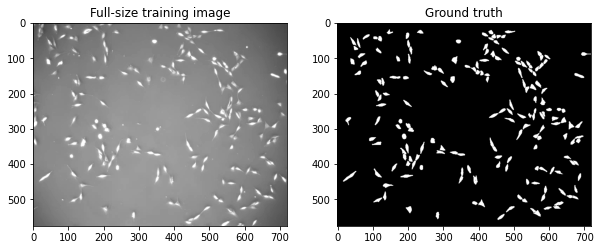

In [4]:
from skimage.util import img_as_ubyte
from skimage import io
import cv2
from matplotlib import pyplot as plt

# read training images
train_img = [cv2.imread(train_input_path + x, cv2.IMREAD_ANYDEPTH) for x in train_input_filenames ]
train_masks = [cv2.imread(train_output_path + x, cv2.IMREAD_ANYDEPTH) for x in train_output_filenames ]

# display first image
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( train_img[0], 'gray' )
plt.title( 'Full-size training image' )
# and its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( train_masks[0], 'gray' )
plt.title( 'Ground truth' )


Next, we read the 16 images for the validation.

Images loaded: 16


Text(0.5, 1.0, 'Ground truth')

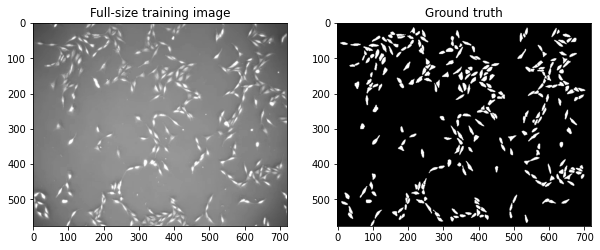

In [5]:
# Path to the validation images
val_input_path = 'drive/My Drive/PhC-C2DL-PSC/validation/input/'
val_output_path = 'drive/My Drive/PhC-C2DL-PSC/validation/output/'

# Read the list of file names and sort them to have a match between images and masks
val_input_filenames = [x for x in os.listdir(val_input_path ) if x.endswith(".tif")]
val_input_filenames.sort()
val_output_filenames = [x for x in os.listdir(val_output_path ) if x.endswith(".tif")]
val_output_filenames.sort()

print( 'Images loaded: ' + str( len(val_input_filenames)) )

# read training images
val_img = [cv2.imread(val_input_path + x, cv2.IMREAD_ANYDEPTH) for x in val_input_filenames ]
val_masks = [cv2.imread(val_output_path + x, cv2.IMREAD_ANYDEPTH) for x in val_output_filenames ]

# display first image
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(val_img[0], 'gray' )
plt.title( 'Full-size training image' )
# and its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow(val_masks[0], 'gray' )
plt.title( 'Ground truth' )

## Preparing the training data
Now, we are going to create the training set by cropping the input images into **patches of 256 x 256 pixels**.


There are 606 patches to train the network
There are 96 patches to train the network


Text(0.5, 1.0, 'Binary patch (ground truth)')

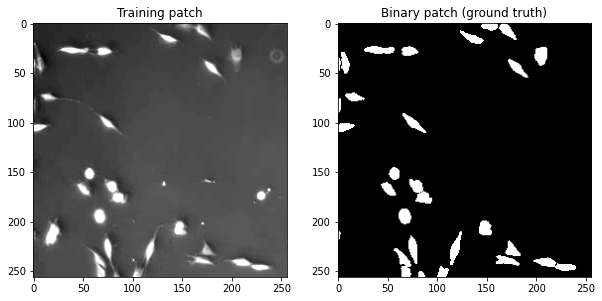

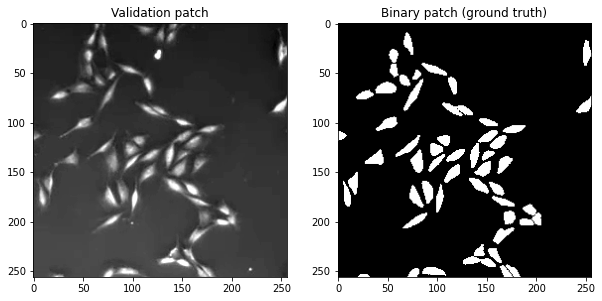

In [6]:
# Create patches of 256x256 pixels
# and do the same with the binary masks

import numpy as np
def create_ranodm_patches( imgs, masks, num_patches, shape ):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs: list of input images
        masks: list of binary masks (output images) corresponding to imgs.
        num_patches: number of patches for each image
        shape: 2D array with the size of the patches. Example: [256, 256]
        
    Returns:
        list of image patches and patches of corresponding binary masks
    '''
    original_size = imgs[0].shape
    
    input_patches = []
    output_patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        mask = masks[ n ]
        for i in range( num_patches ):
          r = np.random.randint(0,original_size[0]-shape[0])
          c = np.random.randint(0,original_size[1]-shape[1])
          input_patches.append( image[ r : r + shape[0],
                                  c : c + shape[1] ] )
          output_patches.append( mask[ r : r + shape[0],
                                  c : c + shape[1] ] )
    return input_patches, output_patches


# Use the method to create patches
train_input_patches, train_output_patches = create_ranodm_patches( train_img, train_masks, 6, [256,256]) # 25 patches when there is not too much data
print('There are {} patches to train the network'.format(len(train_input_patches)))

# Display one patch
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( train_input_patches[0], 'gray' )
plt.title( 'Training patch' )
# and its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( train_output_patches[0], 'gray' )
plt.title( 'Binary patch (ground truth)' )

# Use the method to create patches
val_input_patches, val_output_patches = create_ranodm_patches( val_img, val_masks, 6, [256,256]) # 25 patches when there is not too much data
print('There are {} patches to train the network'.format(len(val_input_patches)))
# Display one patch
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( val_input_patches[0], 'gray' )
plt.title( 'Validation patch' )
# and its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( val_output_patches[0], 'gray' )
plt.title( 'Binary patch (ground truth)' )

## Network definition
Next, we define our U-Net-like network, with 3 resolution levels in the contracting path, a bottleneck, and 3 resolution levels in the expanding path:

<figure>
<center>
<img src="https://drive.google.com/uc?id=1kjjBP4bTmDUKknRyEn1sF-sG1YZXmSxJ" width="750">
</figure>



As loss function, we use the mean squared error (MSE) between the expected and the predicted pixel values, and we also include the mean absolute error (MAE) as a control metric.


In [11]:
# Input image size
patch_shape = train_input_patches[0].shape
train_width = patch_shape[0]
train_height = patch_shape[1]

# Create U-Net for super-resolution

from keras.models import Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D
from keras.layers import concatenate

# inputs = Input((train_width, train_height, 1))
inputs = Input((None, None, 1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = AveragePooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = AveragePooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = AveragePooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
# compile the model with Adam as optimizer, BCE as loss function and ACC as metric
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 1 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, None, None, 1 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 1 2320        dropout_8[0][0]                  
__________________________________________________________________________________________________
average_po

## Training the network
To follow Tensorflow standards, the input and output of the network have to be reshaped to 256 x 256 x 1. Notice both input and ground truth images have their intensities scaled between 0.0 and 1.0.

Important training information:
*   `Model checkpoint`: a checkpoint of the model is stored in the path 'drive/My Drive/PhC-C2DL-PSC/models/checkpoint' under the name `unet_pancreatic_cell_segmentation.h5`. Change it if you want to be in a different path or with a different name.
*   `Validation split`: percentage of training samples used for validation. Set to a random 10%.
*   `Epochs`: which defines the maximum number of epochs the model will be trained. Initially set to 100.
*   `Patience`: number of epochs that produced the monitored quantity (validation MSE) with no improvement after which training will be stopped. Initially set to 10.
*   `Batch size`:  the number of training examples in one forward/backward pass. Initially set to 6.



In [12]:
# Train the network
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

numEpochs = 100
earlystopper = EarlyStopping(patience=50, verbose=1, restore_best_weights=True)
checkpoint_path = 'drive/My Drive/PhC-C2DL-PSC/models/checkpoint'
if not os.path.exists(checkpoint_path):
  os.makedirs(checkpoint_path)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'unet_pancreatic_cell_segmentation.h5'),
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
# Input image size
patch_shape = train_input_patches[0].shape
train_width = patch_shape[0]
train_height = patch_shape[1]

# training input
input_shape = ( train_width, train_height, 1 ) # 256x256x1
X_train = [x/np.max(x) for x in train_input_patches] # normalize between 0 and 1
X_train = [np.reshape(x, input_shape ) for x in X_train]
X_train = np.asarray(X_train)

# training ground truth
output_shape = ( train_width, train_height, 1 ) # 256x256x1
Y_train = [np.reshape( x, output_shape ) for x in train_output_patches]
Y_train = np.asarray(Y_train)

# validation input
input_shape = ( train_width, train_height, 1 ) # 256x256x1
X_val = [x/np.max(x) for x in val_input_patches] # normalize between 0 and 1
X_val = [np.reshape(x, input_shape ) for x in X_val]
X_val = np.asarray(X_val)

# validation ground truth
output_shape = ( train_width, train_height, 1 ) # 256x256x1
Y_val = [np.reshape( x, output_shape ) for x in val_output_patches]
Y_val = np.asarray(Y_val)

# Train the model using a 10% validation split and batch size of 6
history = model.fit( X_train, Y_train, validation_data = (X_val, Y_val), batch_size = 2,
                    epochs=numEpochs, callbacks=[earlystopper, model_checkpoint])

Train on 606 samples, validate on 96 samples
Epoch 1/100
606/606 [==============================] - 22s 36ms/step - loss: 0.1212 - acc: 0.9580 - val_loss: 0.0720 - val_acc: 0.9735
Epoch 2/100
606/606 [==============================] - 20s 33ms/step - loss: 0.0618 - acc: 0.9755 - val_loss: 0.0540 - val_acc: 0.9796
Epoch 3/100
606/606 [==============================] - 20s 33ms/step - loss: 0.0538 - acc: 0.9784 - val_loss: 0.0480 - val_acc: 0.9816
Epoch 4/100
606/606 [==============================] - 20s 33ms/step - loss: 0.0472 - acc: 0.9808 - val_loss: 0.0436 - val_acc: 0.9832
Epoch 5/100
606/606 [==============================] - 20s 33ms/step - loss: 0.0415 - acc: 0.9829 - val_loss: 0.0417 - val_acc: 0.9841
Epoch 6/100
606/606 [==============================] - 20s 33ms/step - loss: 0.0379 - acc: 0.9843 - val_loss: 0.0430 - val_acc: 0.9840
Epoch 7/100
606/606 [==============================] - 20s 33ms/step - loss: 0.0352 - acc: 0.9854 - val_loss: 0.0434 - val_acc: 0.9835
Epoch 8/10


We can now plot the loss and MAE curves for the training and validation sets.


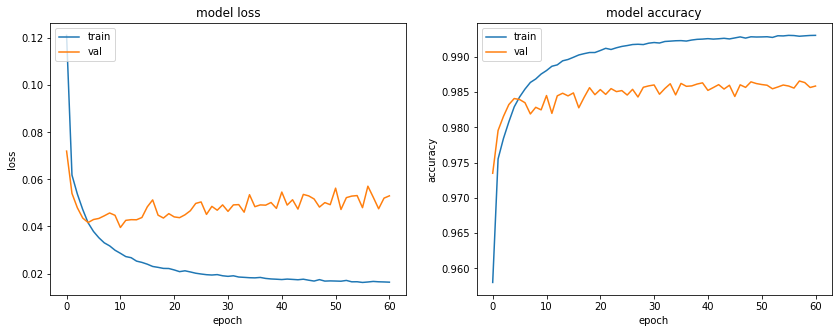

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# summarize history for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Check performance in the test set
Finally we can load some test images for testing.

In [14]:
# Now we load some unseen images for testing
test_input_path = 'drive/My Drive/PhC-C2DL-PSC/test/input/'
test_output_path = 'drive/My Drive/PhC-C2DL-PSC/test/output/'

test_input_filenames = [x for x in os.listdir( test_input_path ) if x.endswith(".tif")]
test_input_filenames.sort()
test_output_filenames = [x for x in os.listdir( test_output_path ) if x.endswith(".tif")]
test_output_filenames.sort()

print( 'Available test images: ' + str( len(test_input_filenames)) )

Available test images: 85


Text(0.5, 1.0, 'Ground truth')

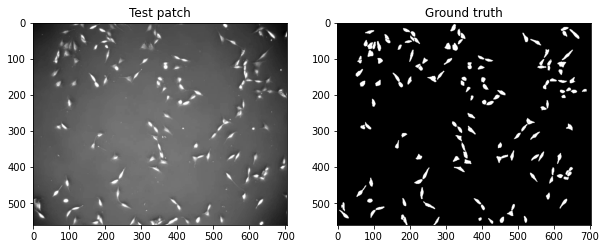

In [15]:
# Read test images
test_img = [cv2.imread(test_input_path + x, cv2.IMREAD_ANYDEPTH) for x in test_input_filenames ]
test_mask = [cv2.imread(test_output_path + x, cv2.IMREAD_ANYDEPTH) for x in test_output_filenames ]

# Create patches the same way as before
test_input_patches, test_output_patches = create_ranodm_patches( test_img, test_mask, 1, [560,704])

# Display corresponding first patch at low resolution
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( test_input_patches[0], 'gray' )
plt.title( 'Test patch' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( test_output_patches[0], 'gray' )
plt.title( 'Ground truth' )



We can evaluate the network performance in test using both the BCE and accuracy metrics.


In [16]:
# Evaluate trained network on test images
# training input
input_shape = ( 560, 704, 1 ) # 256x256x1
X_test = [x/np.max(x) for x in test_input_patches] # normalize between 0 and 1
X_test = [np.reshape(x, input_shape ) for x in X_test]
X_test = np.asarray(X_test)

output_shape = ( 560, 704, 1 ) # 256x256x1
Y_test = [np.reshape( x, output_shape ) for x in test_output_patches]
Y_test = np.asarray(Y_test)

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test , batch_size=16)
print('test loss BCE: {0}, test accuracy: {1}'.format(results[0], results[1]))




# Evaluate on test data
85/85 [==============================] - 8s 92ms/step
test loss BCE: 0.0425097500138423, test accuracy: 0.9846655677346622


And also display some patches for qualitative evaluation.


# Generate predictions for 3 samples
predictions shape: (1, 560, 704, 1)
predictions shape: (1, 560, 704, 1)
predictions shape: (1, 560, 704, 1)


Text(0.5, 1.0, 'Binary segmentation')

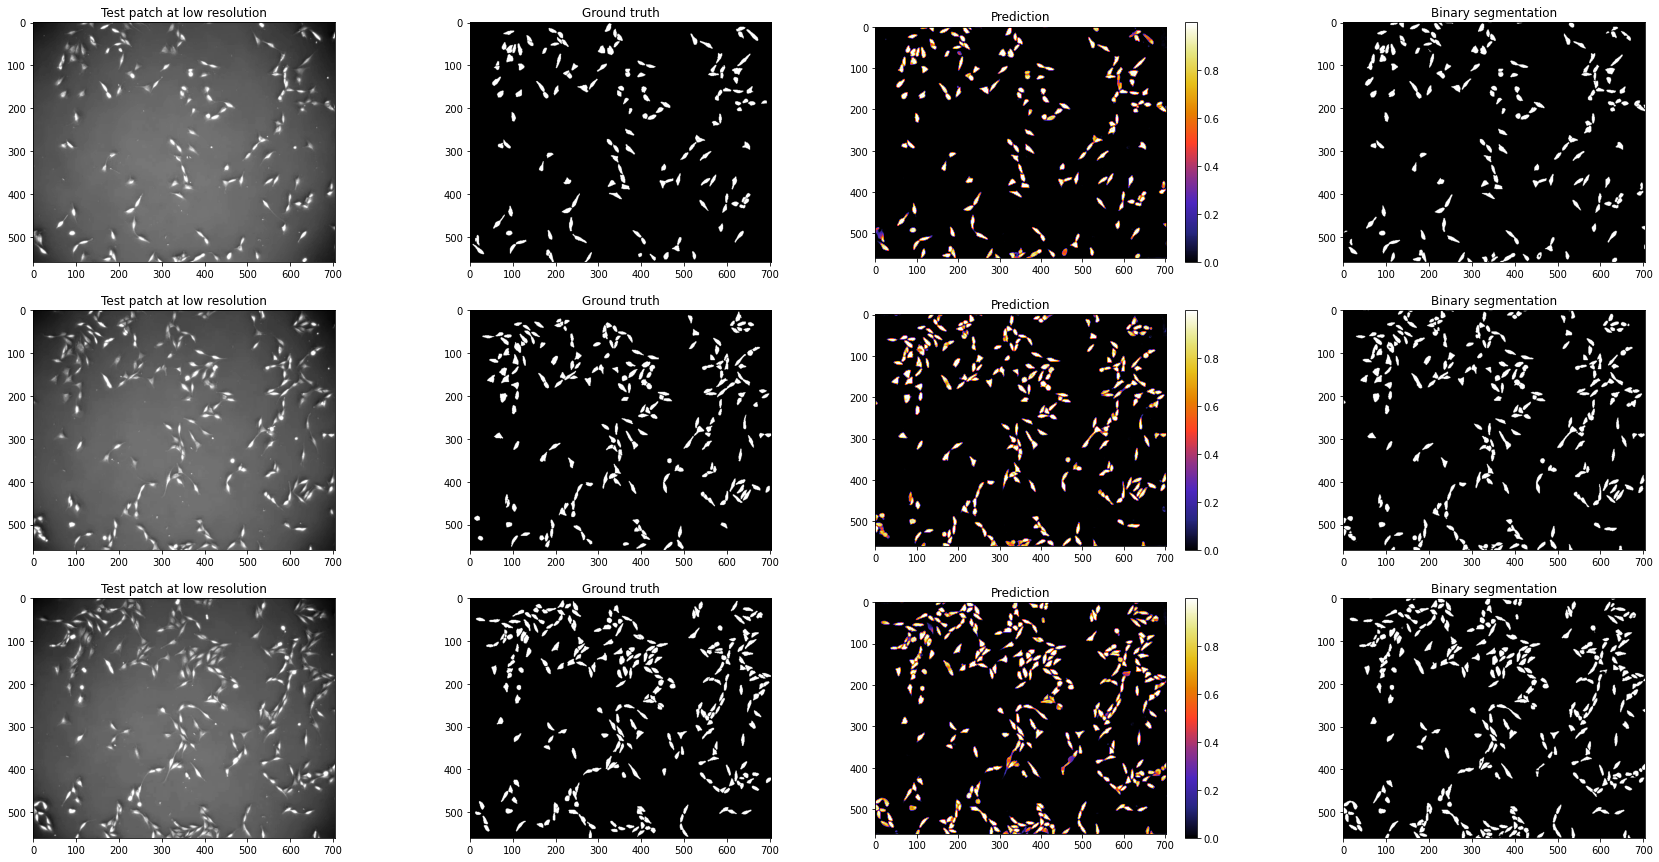

In [18]:
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:1])
print('predictions shape:', predictions.shape)

# Display corresponding first 3 patches
plt.figure(figsize=(30,15))
plt.subplot(3, 4, 1)
plt.imshow( test_input_patches[0], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 4, 2)
plt.imshow( test_output_patches[0], 'gray' )
plt.title( 'Ground truth' )
# its prediction
plt.subplot(3, 4, 3)
plt.imshow( predictions[0,:,:,0], 'CMRmap')
plt.colorbar()
plt.title( 'Prediction' )
# and the binary segmentation
plt.subplot(3, 4, 4)
plt.imshow( predictions[0,:,:,0]>0.5, 'gray' )
plt.title( 'Binary segmentation' )

predictions = model.predict(np.expand_dims(X_test[50], axis = 0))
print('predictions shape:', predictions.shape)

plt.subplot(3, 4, 5)
plt.imshow( test_input_patches[50], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 4, 6)
plt.imshow( test_output_patches[50], 'gray' )
plt.title( 'Ground truth' )
# its prediction
plt.subplot(3, 4, 7)
plt.imshow( predictions[0,:,:,0], 'CMRmap' )
plt.colorbar()
plt.title( 'Prediction' )
# and the binary segmentation
plt.subplot(3, 4, 8)
plt.imshow( predictions[0,:,:,0]>0.5, 'gray' )
plt.title( 'Binary segmentation' )

predictions = model.predict(np.expand_dims(X_test[80], axis = 0))
print('predictions shape:', predictions.shape)

plt.subplot(3, 4, 9)
plt.imshow( test_input_patches[80], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 4, 10)
plt.imshow( test_output_patches[80], 'gray' )
plt.title( 'Ground truth' )
# its prediction
plt.subplot(3, 4, 11)
plt.imshow( predictions[0,:,:,0], 'CMRmap' )
plt.colorbar()
plt.title( 'Prediction' )
# and the binary segmentation
plt.subplot(3, 4, 12)
plt.imshow( predictions[0,:,:,0]>0.5, 'gray' )
plt.title( 'Binary segmentation' )


## Save model to import it later in DeepImageJ
Now, we will see how to saved the train model into a file so we can later reuse it in the [DeepImageJ plugin](https://deepimagej.github.io/deepimagej/index.html).

In [19]:
# !rm -rf save_model

# Save entire model to the Tensorflow format SavedModel

import tensorflow as tf
import keras
from keras import backend as K

OUTPUT_DIR = "./saved_model"

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  model.input},
            outputs = {'output': model.output})

signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./saved_model/saved_model.pb


b'./saved_model/saved_model.pb'

In [20]:
# Check if the folder has been properly created
!ls -l

total 12
drwx------ 5 root root 4096 Jun 23 11:46 drive
drwxr-xr-x 1 root root 4096 Jun 17 16:18 sample_data
drwxr-xr-x 3 root root 4096 Jun 23 12:22 saved_model


In [21]:
# Zip folder with the save model
from google.colab import files

!zip saved_model -r saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 61%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/saved_model.pb (deflated 91%)


In [22]:
# Check if the file is there
!ls -l

total 10528
drwx------ 5 root root     4096 Jun 23 11:46 drive
drwxr-xr-x 1 root root     4096 Jun 17 16:18 sample_data
drwxr-xr-x 3 root root     4096 Jun 23 12:22 saved_model
-rw-r--r-- 1 root root 10765299 Jun 23 12:22 saved_model.zip


In [23]:
# And download!
files.download("saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Calculate the size of the halo.

The halo is determined by the receptive field of one pixel in the image: if there was any kind of padding in the convolutions, then the result for the pixels in the corners is affected by this padding. We need to determine how far from the edges we need to be, in order to avoid the effect of that padding. This is the same as calculating the receptive field of one pixel to determine the cummulative padding performed along the network architecture. 

Then the halo, is exactly the size of this receptive field:

*   Two images that are almost the same are analyzed. The first one is a null image and the second one is a null image with a centered unitary pixel. 

*    When processing both images with the model, it seems that the output is the same. However, when the absolute difference is computed, we can notice that it is only the same in the halo, where the convolutions are influenced by the padding and not the content of the image.

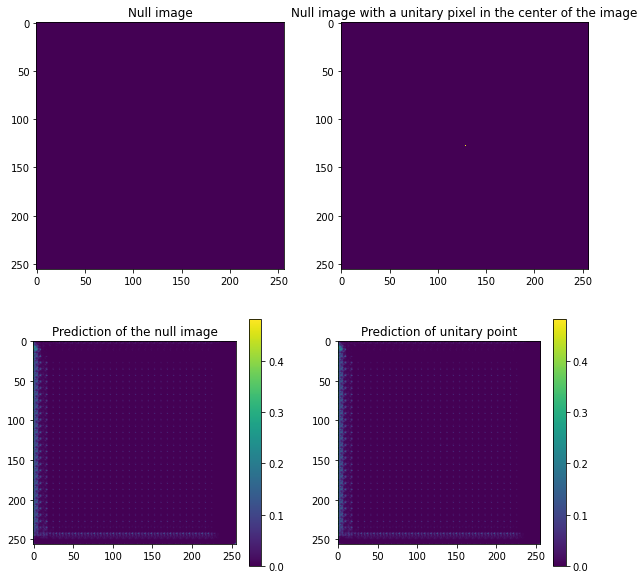

In [114]:
null_im = np.zeros((1,256,256,1))
point_im = np.zeros_like(null_im)
point_im[0,128,128,0] = 1

result_unit = model.predict(np.concatenate((null_im, point_im)))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(null_im[0,:,:,0])
plt.title('Null image')

plt.subplot(2,2,2)
plt.imshow(point_im[0,:,:,0])
plt.title('Null image with a unitary pixel in the center of the image')

plt.subplot(2,2,3)
plt.imshow(result_unit[0,:,:,0])
plt.colorbar()
plt.title('Prediction of the null image')

plt.subplot(2,2,4)
plt.imshow(result_unit[1,:,:,0])
plt.colorbar()
plt.title('Prediction of unitary point')
plt.show()

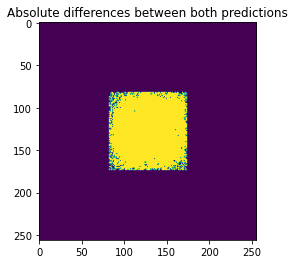

In [115]:
plt.figure()
D = np.abs(result_unit[0]-result_unit[1])>0
D = D[:,:,0]
plt.imshow(D)
plt.title('Absolute differences between both predictions')
plt.show()

As the kernels in the network are usually squared (size = (3,3)), we just need to measure the halo for one of the axes

In [135]:
ind = np.where(D[:128,:128]==1)
halo = np.min(ind[1])
print('The size of the halo in this case is {0}'.format(128-halo+1))

The size of the halo in this case is 47
